Alle packages die we gebruiken. Mocht hij een foutmelding geven bij één van de packages omdat je hem niet hebt, dan kan je hem in het lege code blokje hieronder installeren, via pip. Typ dan bijvoorbeeld:

!pip install pandas <br>
!pip install matplotlib <br>
!pip install scipy <br>

In [1]:
import requests
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

from scipy.stats import skewnorm

# MapBox API
Hieronder is de code die gebruikt wordt om data te pakken van de MapBox API. Een API is een soort verbindpunt die een bedrijf kan maken, waar programmeurs aanspraak op kunnen maken. Je stuurt wat naar het bedrijf, en je krijgt wat terug. Het bedrijf laat hier in weten wat je moet opsturen, en in wat voor formaat.

Mapbox heeft een API die 
1. De coordinaten kan geven van een adres --> Je geeft dus "Hoogstraat 59, Eindhoven" als input en je krijgt [5.471644, 51.433447]	terug.
2. Route informatie kan geven op basis van twee coordinaten --> Je geeft dus ([5.471644, 51.433447], [5.462197, 51.431669]) en je krijgt alle informatie over de route tussen die twee punten. Hierin moet je ook zelf aangeven wat de manier van vervoer was.

We gebruikten eerste OpenRouteService als API, we zijn geswitcht naar MapBox omdat deze gebruik kan makken van historische verkeersinformatie op basis van de tijd van de dag.

In [2]:
class MapBoxService():
    def __init__(self, api_key):
        self.api_key = api_key
        self.headers = {'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8'}

    def get_geocode(self, text):
        url = 'https://api.mapbox.com/geocoding/v5/mapbox.places/{}.json?access_token={}'.format(
            text,
            self.api_key
        )
        req = requests.get(url=url, headers=self.headers)
        
        if (req.status_code == 200):
            req_data = req.json()
            coords = req_data['features'][0]['geometry']['coordinates']
            return coords

        print('Directions response status : ', req.status_code, req.reason, text)
        
    def get_directions(self, start, end, mode, include_historical_traffic,timestamp = None):
        try:
            if mode == 'On foot':
                url = 'https://api.mapbox.com/directions/v5/mapbox/walking/{},{};{},{}?access_token={}'.format(
                    start[0], start[1],
                    end[0], end[1],
                    self.api_key)
            elif mode == 'By bike':
                url = 'https://api.mapbox.com/directions/v5/mapbox/cycling/{},{};{},{}?access_token={}'.format(
                    start[0], start[1],
                    end[0], end[1],
                    self.api_key)
            elif mode == 'By car':
                timestamp_iso = timestamp.strftime('%Y-%m-%dT%H:%M')
                if include_historical_traffic:
                    url = 'https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{},{};{},{}?access_token={}&depart_at={}'.format(
                        start[0], start[1],
                        end[0], end[1],
                        self.api_key,
                        timestamp_iso)
                else:
                    url = 'https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{},{};{},{}?access_token={}&depart_at={}'.format(
                        start[0], start[1],
                        end[0], end[1],
                        self.api_key,
                        timestamp_iso)

            req = requests.get(url=url, headers=self.headers)
        except UnboundLocalError:
            print(start, end, mode, timestamp)
            
        if (req.status_code == 200):
            req_data = req.json()

            return req_data
                
    def plot_directions(self, coords, timestamps, locations, filename):
        client = openrouteservice.Client(key='5b3ce3597851110001cf6248e71bc6969df240ac8acdc15daf25a457')
        res = client.directions(coords)
        geometry = client.directions(coords)['routes'][0]['geometry']
        decoded = convert.decode_polyline(geometry)

        distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['distance']/1000,1))+" Km </strong>" +"</h4></b>"
        duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['duration']/60,1))+" Mins. </strong>" +"</h4></b>"
        center = [np.mean([x[1] for x in coords]), np.mean([x[0] for x in coords])]
        
        m = folium.Map(location=center, zoom_start=10, control_scale=True,tiles="cartodbpositron")
        folium.GeoJson(decoded).add_child(folium.Popup(distance_txt+duration_txt,max_width=300)).add_to(m)

        for idx, coord in enumerate(coords):
            location_txt = "<h4> <b>Location :&nbsp" + "<strong>"+ locations[idx] +" Km </strong>" +"</h4></b>"
            timestamp_txt = "<h4> <b>Timestamp :&nbsp" + "<strong>"+ str(timestamps[idx]) +" Mins. </strong>" +"</h4></b>"
            
            popup = folium.Popup(location_txt+timestamp_txt,max_width=300)
            folium.Marker(
                location=coord[::-1],
                icon=folium.Icon(color="green"),
                popup=popup
            ).add_to(m)
        
        m.save(filename)

In [3]:
with open(file='ors_token.txt', mode='r') as file:
    keys = file.readlines()
    
mbs_api = MapBoxService(api_key=keys[1])

# Verwerken data

Voor al het werk dat we doen met de data doen, gebruiken we pandas. Pandas is de industrie standaard in Python voor data verwerken en analyzeren. Een of andere website:

Pandas has been one of the most commonly used tools for Data Science and Machine learning, which is used for data cleaning and analysis.

Here, Pandas is the best tool for handling this real-world messy data. And pandas is one of the open-source python packages built on top of NumPy.

Handling data using pandas is very fast and effective by using pandas Series and data frame, these two pandas data structures will help you to manipulate data in various ways.

Based on the features available in pandas we can say pandas is best for handling data. It can handle missing data, cleaning up the data and it supports multiple file formats. This means it can read or load data in many formats like CSV, Excel, SQL, etc.,

Let’s take an example and see how it’s gonna read CSV data.

In [4]:
## Loading data, for now from .csv -> might become a tool
data = pd.read_csv('case_data.csv')
orig_cols = list(data.columns)

data['timestamp'] = pd.to_datetime(data['timestamp'])

# Get geodata first so we can drop events that the API cannot find coordinates of
data['location_coords'] = data['location'].apply(lambda x: mbs_api.get_geocode(text=x))

# Sort data by timestamp to have character indices in alphabetical and chronological order
data = data.sort_values('timestamp')

# Change index to characters
data.index = [chr(ord('a') + i) for i in range(len(data))]

# Change column order
data = data[['method', 'timestamp', 'location', 'location_coords', 'transportmode', 'confirmed']]

# Drop any empty rows that might have occured
data = data.dropna(subset=['timestamp', 'location'])
data

,method,timestamp,location,location_coords,transportmode,confirmed
a,Zendmasten,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn","[5.9948842, 52.2012027]",On foot,No
b,Zendmasten,2013-08-06 13:10:00,"Gijsbrechtgaarde, Apeldoorn","[5.9948842, 52.2012027]",On foot,Yes
c,Camerabeelden,2013-08-06 13:33:00,"Koestraat, Zwolle","[6.0935857, 52.5101125]",By car,No
d,Delict,2013-08-06 13:46:00,"Koestraat, Zwolle","[6.0935857, 52.5101125]",On foot,No
e,Camerabeelden,2013-08-06 14:09:00,"Koestraat, Zwolle","[6.0935857, 52.5101125]",On foot,No
f,Camerabeelden,2013-08-06 14:56:00,"Koestraat, Zwolle","[6.0935857, 52.5101125]",On foot,Yes
g,Bankgegevens,2013-08-06 15:45:00,"De Eglantier, Apeldoorn","[6.0051501, 52.1953227]",On foot,Yes
h,Bankgegevens,2013-08-06 15:51:00,"De Eglantier, Apeldoorn","[6.0051501, 52.1953227]",On foot,Yes


# Routes Pre-computing
Als we voor elke combinatie van locaties en tijden elke keer de route moeten gaan halen uit de API, zijn we super veel extra werk aan het doen. Welke combinatie met a, b, c, en d je ook hebt, de route van a-c gaat elke keer hetzelfde zijn. We kunnen dus beter van te voren deze allemaal een keer berekenen, en daarna opvragen als we de kans moeten gaan berekenen. Scheelt honderden API calls.

De kansberekening gaat iets anders voor lopen en fietsen dan voor rijden. Voor lopen en fietsen vergelijkt hij de gemiddelde snelheid (bietje natte vingerwerk, moeten we nog mooie getallen aan binden) met de snelheid die hij had moeten lopen volgens de events die we hebben. Bij autorijden vergelijkt hij de snelheid die de API zegt dat je gemiddeld over dat traject rijst met de snelheid die hij had moeten lopen volgens de events die we hebben.

De verdeling is een skewnormal verdeling met een skew naar rechts, dat betekent dat de kans dat het 'makkelijker' is (lees: een grotere kans heeft) om langzamer te zijn dan een gemiddelde snelheid, dan sneller. Als de gemiddelde snelheid bij lopen 1.5 m/s is, dan is het 'makkelijker' om m/s te hebben gelopen over die afstand dan om 2 m/s te hebben gelopen). We delen alle waardes in de verdeling door de waarde van de piek, hierdoor wordt de hele verdeling 'opgeschaald', waardoor de piek een waarde krijgt van 1 en de rest naar verhouding mee is geschaald (zie plot)

We werkte eerst met de duration van de route (hoe groot is de kans dat iemand een route van "gemiddeld" 1000 seconden aflegt in 800 seconden), maar dit had niet het gewenste resultaat. Dit kwam omdat je hier geen referentie materiaal voor hebt; bij snelheid weten we hoe snel mensen kunnen lopen en kunnen we kijken of de gespotte snelheid mogelijk zou zijn -> deze gemiddelde snelheid is natuurlijk altijd hetzelfde. 

In [65]:
def get_probability(speed: float, speed_api: float, mode: str) -> float:
    if speed == 0:
        return 1
    elif mode == 'On foot':
        mu = 1.5
    elif mode == 'By bike':
        mu = 4
    elif mode == 'By car':
        mu = speed_api
    else:
        return 0.5

    std = 0.7 * mu
    dist = skewnorm(a=-1, loc=mu, scale=std)
    max_val = np.max(dist.pdf(np.linspace(mu-std, mu+std, 200)))
    prob = dist.pdf(speed) / max_val

    if prob > 1:
        print(f"Mode: {mode}, Speed: {speed}, Speed API: {speed_api}, Prob: {prob}")

    return prob

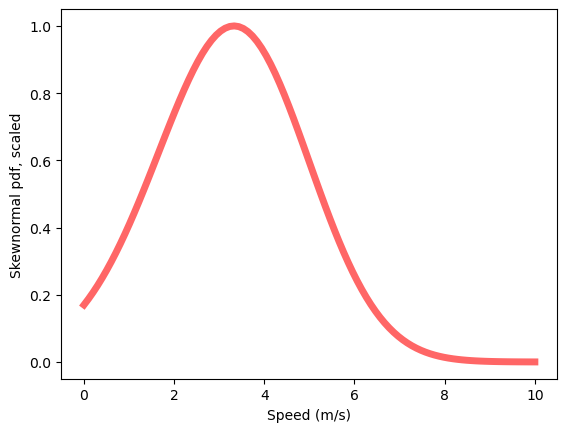

In [10]:
# Voorbeeld van de verdeling 
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
mu = 4.37
std = 2.06

dist = skewnorm(a=-1, loc=mu, scale=std)
y = dist.pdf(x) / np.max(dist.pdf(np.linspace(mu-std, mu+std, 200)))

plt.plot(x, y,
       'r-', lw=5, alpha=0.6, label='skewnorm pdf')

plt.xlabel("Speed (m/s)")
plt.ylabel("Skewnormal pdf, scaled")

plt.show()

This is where we pre-process all the possible pairs of events. We first get all possible pairs that you can make with the indices -> (n * n-1) / 2 pairs. If we have all those pairs (ab, ac, ad, ae, bc, bd, ...) we get information from the original data again (the pd.merge function).

Afterwards, we use the Mapbox api to get all the direction information -> mainly the duration of the travel and the distance, from which we can also infer the average speed. Based on the speed as given by the events and by the API, we calculate the probability as explained above.|

In [68]:
# Get all possible pairs
pairs = list(itertools.combinations(data.index, 2))
possible_routes = pd.DataFrame(zip(*pairs)).T
possible_routes = possible_routes.rename(columns= {0: 'start_event', 1: 'end_event'})

# After getting all the possible routes, we merge it with the original data to get all corresponding coordinates
possible_routes = pd.merge(possible_routes, data.add_prefix('start_'), how='left', left_on='start_event', right_index=True)
possible_routes = pd.merge(possible_routes, data.add_prefix('end_'), how='left', left_on='end_event', right_index=True)

# Based on the sightings we can get the difference between the start and end timestamp to get a suspected 'speed'
possible_routes['duration'] = (possible_routes['end_timestamp'] - possible_routes['start_timestamp']).dt.total_seconds()

# This is where we get the data from the MapBox API. We have to provide a starting coordinate, end coordinate, mode of transportation and the timestamp (in the case of driving mode)
possible_routes['directions'] = possible_routes.apply(lambda x: mbs_api.get_directions(start=x['start_location_coords'], 
                                                                                       end=x['end_location_coords'],
                                                                                       mode=x['end_transportmode'],
                                                                                       include_historical_traffic=True,
                                                                                       timestamp=x['start_timestamp']), axis=1)

# This is where we grab the distance between point A and point B, as given by Mapbox.
possible_routes['distance_api'] = possible_routes['directions'].apply(lambda x: x['routes'][0]['distance'])
possible_routes['duration_api'] = possible_routes['directions'].apply(lambda x: x['routes'][0]['duration'])

# From the distance computed by the APi and the difference between the start and end timestamp we can get an average speed
possible_routes['speed'] = possible_routes['distance_api'] / possible_routes['duration']
possible_routes['speed_api'] = possible_routes['distance_api'] / possible_routes['duration_api']

## Assigning probabilities
possible_routes['probability'] = possible_routes.apply(lambda x: get_probability(speed = x['speed'],
                                                                                 speed_api = x['speed_api'],
                                                                                 mode = x['end_transportmode']), axis=1)

# We can only keep the columns we are actually interested in, and discard the rest
routing_data = possible_routes[['start_event', 'start_timestamp', 'start_location', 
                                'end_event', 'end_timestamp', 'end_location', 'end_transportmode', 
                                'duration', 'speed', 
                                'distance_api', 'duration_api', 'speed_api',
                                'probability']]
routing_data

,start_event,start_timestamp,start_location,end_event,end_timestamp,end_location,end_transportmode,duration,speed,distance_api,duration_api,speed_api,probability
0,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",b,2013-08-06 13:10:00,"Gijsbrechtgaarde, Apeldoorn",On foot,1200.0,0.000000,0.000,0.000,NaN,1.000000e+00
1,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",c,2013-08-06 13:33:00,"Koestraat, Zwolle",By car,2580.0,16.331221,42134.551,2044.114,20.612623,9.670191e-01
2,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",d,2013-08-06 13:46:00,"Koestraat, Zwolle",On foot,3360.0,11.735820,39432.355,27827.373,1.417035,3.551879e-43
3,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",e,2013-08-06 14:09:00,"Koestraat, Zwolle",On foot,4740.0,8.319062,39432.355,27827.373,1.417035,4.743566e-20
4,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",f,2013-08-06 14:56:00,"Koestraat, Zwolle",On foot,7560.0,5.215920,39432.355,27827.373,1.417035,6.276911e-07
5,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",g,2013-08-06 15:45:00,"De Eglantier, Apeldoorn",On foot,10500.0,0.111420,1169.908,814.170,1.436933,6.199305e-01
6,a,2013-08-06 12:50:00,"Gijsbrechtgaarde, Apeldoorn",h,2013-08-06 15:51:00,"De Eglantier, Apeldoorn",On foot,10860.0,0.107726,1169.908,814.170,1.436933,6.174468e-01
7,b,2013-08-06 13:10:00,"Gijsbrechtgaarde, Apeldoorn",c,2013-08-06 13:33:00,"Koestraat, Zwolle",By car,1380.0,30.532283,42134.551,2043.938,20.614398,3.182485e-01
8,b,2013-08-06 13:10:00,"Gijsbrechtgaarde, Apeldoorn",d,2013-08-06 13:46:00,"Koestraat, Zwolle",On foot,2160.0,18.255720,39432.355,27827.373,1.417035,1.039130e-112
9,b,2013-08-06 13:10:00,"Gijsbrechtgaarde, Apeldoorn",e,2013-08-06 14:09:00,"Koestraat, Zwolle",On foot,3540.0,11.139083,39432.355,27827.373,1.417035,1.769663e-38


Here we can get all the possible combinations 

In [69]:
# Start with empty list
include = []
min_length = 2

c = [[]]

# If we include the 'confirmed' locations, we add those together with any other included points, 
# if not, we do only the included points (can be empty)
include.extend(list(data[data['confirmed'] == 'Yes'].index))

for idx in data.index:
    # Nifty little code to get all possible combinations in order
    c = c + [r+[idx] for r in c]

if len(include) > 0:
    # If we have any positions that have to be present in any combination, we check for those here.
    c = [x for x in c if set(include).issubset(x)]

# We only keep the combinations that have the minimum required length, standard 
possible_combinations_idx = [x for x in c if len(x) >= min_length]
print(f"Always include: {include}")
possible_combinations_idx

Always include: ['b', 'f', 'g', 'h']


[['b', 'f', 'g', 'h'],
 ['a', 'b', 'f', 'g', 'h'],
 ['b', 'c', 'f', 'g', 'h'],
 ['a', 'b', 'c', 'f', 'g', 'h'],
 ['b', 'd', 'f', 'g', 'h'],
 ['a', 'b', 'd', 'f', 'g', 'h'],
 ['b', 'c', 'd', 'f', 'g', 'h'],
 ['a', 'b', 'c', 'd', 'f', 'g', 'h'],
 ['b', 'e', 'f', 'g', 'h'],
 ['a', 'b', 'e', 'f', 'g', 'h'],
 ['b', 'c', 'e', 'f', 'g', 'h'],
 ['a', 'b', 'c', 'e', 'f', 'g', 'h'],
 ['b', 'd', 'e', 'f', 'g', 'h'],
 ['a', 'b', 'd', 'e', 'f', 'g', 'h'],
 ['b', 'c', 'd', 'e', 'f', 'g', 'h'],
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']]

In [70]:
def transform_to_timeline(data):
    # With this code, we go from the original data structure
    # a - time - location
    # b - time - location
    # c - time - location
    # To the 'timeline' structure, so like directions:
    # a - time_a - location_a - b - time_b - location_b
    # b - time_b - location_b - c - time_c - location_c
    
    # Every event is uniquely identified by the location and the timestamp.
    
    data_shifted = data.shift(-1).add_prefix('end_')
    temp = pd.concat([data.add_prefix('start_'), data_shifted], axis=1)    
    temp = temp.rename(columns={'timestamp': 'start_timestamp', 'location': 'start_location'})
    temp = temp.dropna(subset=['end_timestamp', 'end_location']) 
    temp = temp[['start_timestamp', 'start_location', 'end_timestamp', 'end_location']]
    
    return temp

def add_probs(probs) -> float:
    # If the probability is exactly 1 (near to impossible), we ignore it when adding the odds
    probs = [p for p in probs if p != 1]
    odds = [p / (1 - p) for p in probs]
    
    # We take the mean of the odds, and convert those back to probability
    combined_odds = np.mean(odds)
    combined_prob = combined_odds / (1 + combined_odds)
    
    return combined_prob

prim_key = ['start_timestamp', 'start_location', 'end_timestamp', 'end_location']
df_all_combinations = list()

for combination in possible_combinations_idx:
    # Filter data to index
    data_combination = data.loc[combination]
    route_name = "".join(combination)

    # Transform data to timeline structure
    data_timeline = transform_to_timeline(data_combination)

    # Get the duration and distance from pre-computed times
    data_timeline = data_timeline.set_index(prim_key).join(routing_data.set_index(prim_key), how='left').reset_index()

    prob = add_probs(data_timeline['probability'])
    df_all_combinations.append((route_name, len(combination), prob))

ranking = pd.DataFrame(df_all_combinations, columns=['combination', 'combination_len', 'probability']).sort_values(['probability', 'combination_len'], ascending=False)
ranking

,combination,combination_len,probability
15,abcdefgh,8,1.892363e-01
7,abcdfgh,7,1.892363e-01
11,abcefgh,7,1.892363e-01
14,bcdefgh,7,1.892363e-01
3,abcfgh,6,1.892363e-01
6,bcdfgh,6,1.892363e-01
10,bcefgh,6,1.892363e-01
2,bcfgh,5,1.892363e-01
1,abfgh,5,1.387234e-10
0,bfgh,4,1.387234e-10


Hieronder zie je hoe de plot gemaakt wordt die we kunnen exporteren m.b.t. Hp/Hd.

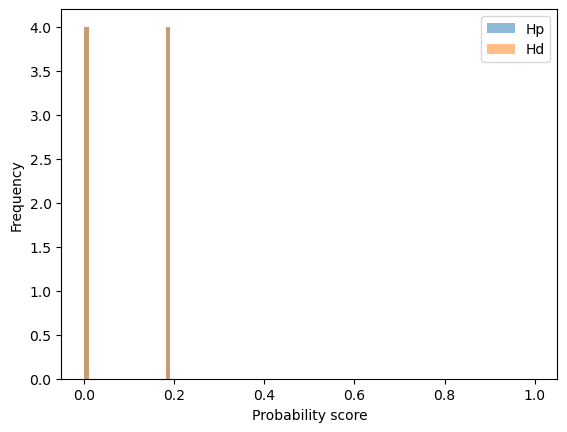

In [71]:
crime_idx = data[data['method'] == 'Delict'].index.values[0]

plt.clf()
            
data_hp = ranking[ranking['combination'].str.contains(crime_idx)]
data_hd = ranking[~ranking['combination'].str.contains(crime_idx)]
bins = np.linspace(0, 1, 100)

plt.hist(data_hp['probability'], bins, alpha=0.5, label='Hp')
plt.hist(data_hd['probability'], bins, alpha=0.5, label='Hd')

plt.xlabel('Probability score')
plt.ylabel('Frequency')

plt.legend(loc='upper right')
plt.show()

In [79]:
print(f"Average Hp probability: {data_hp['probability'].mean()}")
data_hp

Average Hp probability: 0.0946181709581558


,combination,combination_len,probability
15,abcdefgh,8,1.892363e-01
7,abcdfgh,7,1.892363e-01
14,bcdefgh,7,1.892363e-01
6,bcdfgh,6,1.892363e-01
13,abdefgh,7,1.410633e-61
5,abdfgh,6,1.410633e-61
12,bdefgh,6,1.410633e-61
4,bdfgh,5,1.410633e-61


In [78]:
print(f"Average Hd probability: {data_hd['probability'].mean()}")
data_hd

Average Hd probability: 0.09461817099283668


,combination,combination_len,probability
11,abcefgh,7,1.892363e-01
3,abcfgh,6,1.892363e-01
10,bcefgh,6,1.892363e-01
2,bcfgh,5,1.892363e-01
1,abfgh,5,1.387234e-10
0,bfgh,4,1.387234e-10
9,abefgh,6,8.848316e-39
8,befgh,5,8.848316e-39
